In [48]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))

In [49]:
import pandas as pd
import numpy as np

from server.app.database.database import PostgresDatabase


In [50]:
with PostgresDatabase() as db:
    orders_logs = db.fetch(
        "SELECT * FROM orders_logs",
        is_all=True
    )

orders_logs_df = pd.DataFrame(orders_logs)
orders_logs_df.head(10)

,id,customer_id,order_id,change_type,old_price,new_price,price_change_percent,order_name,order_tags,updated_at
0,66,20,3,updated,358.56,322.70,10,Розробка Telegram-бота,"[automation, development]",2025-04-01 17:48:32.687368
1,67,20,76,created,0.00,1121.92,100,ux/ui designer,[design],2025-04-04 17:22:33.024178
2,70,20,79,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:22:58.355289
3,73,20,82,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:22:59.422219
4,76,20,85,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:22:59.991668
5,79,20,88,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:23:00.499329
6,82,20,91,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:23:02.073747
7,85,20,94,created,0.00,311.12,100,Копірайтинг для сайту,"[design, UX/UI, random bullshit]",2025-04-04 17:23:14.816947
8,88,20,97,created,0.00,311.12,100,Копірайтинг для сайту,"[design, UX/UI, random bullshit]",2025-04-04 17:23:15.454604
9,90,20,99,created,0.00,311.12,100,Копірайтинг для сайту,"[design, UX/UI, random bullshit]",2025-04-04 17:23:15.779034


In [51]:
from sklearn.preprocessing import MultiLabelBinarizer

In [52]:
mlb = MultiLabelBinarizer()
tags_ohe = mlb.fit_transform(orders_logs_df["order_tags"])
tags_ohe_df = pd.DataFrame(tags_ohe, columns=mlb.classes_)


In [53]:
tags_ohe_df.head(10)

,UX/UI,automation,design,development,marketing,random bullshit,writing
0,0,1,0,1,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,1,1
3,0,0,1,0,0,1,1
4,0,0,1,0,0,1,1
5,0,0,1,0,0,1,1
6,0,0,1,0,0,1,1
7,1,0,1,0,0,1,0
8,1,0,1,0,0,1,0
9,1,0,1,0,0,1,0


In [54]:
from sklearn.preprocessing import OneHotEncoder

In [55]:
encoder = OneHotEncoder()
encoder.fit(orders_logs_df[["change_type"]])
change_types_ohe = encoder.transform(orders_logs_df[["change_type"]]).toarray()
change_types_ohe_df = pd.DataFrame(change_types_ohe, columns=encoder.get_feature_names_out(["change_type"]))

In [56]:
change_types_ohe_df.head(10)

,change_type_created,change_type_updated
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [66]:
y = orders_logs_df["new_price"]

X = pd.concat([
    tags_ohe_df,
    change_types_ohe_df
], axis=1)

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [67]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [68]:
y_pred = model.predict(X_test)

In [69]:
print("Regression coefficients for new_price with regressors as order_tags:")
print(model.coef_)

print("\nTest data prediction:")
print(y_pred[:5]) 

Regression coefficients for new_price with regressors as order_tags:
[-107.22204983   12.40524441  138.88218009 -104.61550507   -6.99440271
   30.10076384   50.24903981   -5.60712906    5.60712906]

Test data prediction:
[493.90932023 738.41916191 496.23828939 914.93326701 914.93326701]


In [70]:
mse = mean_squared_error(y_test, y_pred)
print("\nMSE):", mse)

r2 = r2_score(y_test, y_pred)
print("\nR^2:", r2)


MSE): 102181.56631347568

R^2: -0.02143650674799913


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

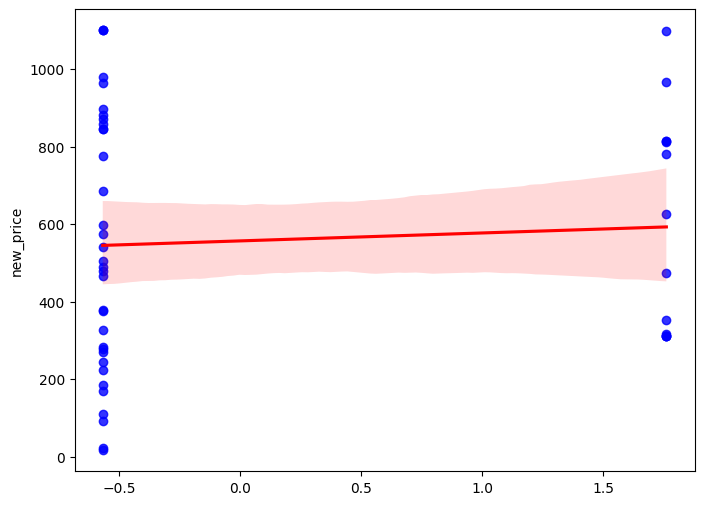

In [72]:
y_test = y_test.astype(np.float64)

plt.figure(figsize=(8, 6))
sns.regplot(x=X_test[:, 0], y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.show()